In [1]:
import Pkg; Pkg.add(["Plots", "SpecialFunctions", "Polynomials"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = true;

In [3]:
using LinearAlgebra;
using Plots; plotlyjs(); default(l=5, size=(900,550), label=false);
using Printf;
using Polynomials;

BLAS.set_num_threads(1)

default(fmt=:png)

prettyprint(a) = map(x -> @sprintf("%+.2f", x), v)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

### Warmup

# Backward Error Analysis

**1. Review & backward stability of floating point**

**2. Examples of stable and unstable algorithms**

## Review

### Relative conditioning ...

Given problem $f: X \to Y$, the _relative condition number_ $\kappa(x)$ is

$$ \kappa(x) =  \lim_{\rho\to 0} \sup_{\|\delta x\| \leq \rho} \frac{\|f(x + \delta x) - f(x)\| / \|f(x)\|}{\|\delta x\| / \|x\|}$$

### ... of $A: x \mapsto Ax$, $A^{-1}: b \to A^{-1} b$, or $b: A \mapsto A^{-1} b$ ($A\in\mathbb{C}^{m \times m}$ invertible)

For each of these problems, the condition number is the matrix condition number of $A$:

$$\kappa(A) = \|A\|\|A^{-1}\| \geq 1.$$

### If $\|\cdot\| = \|\cdot\|_2$,

$$\kappa(A) = \|A\|_2 \|A^{-1}\|_2 = \frac{\sigma_1}{\sigma_m}.$$

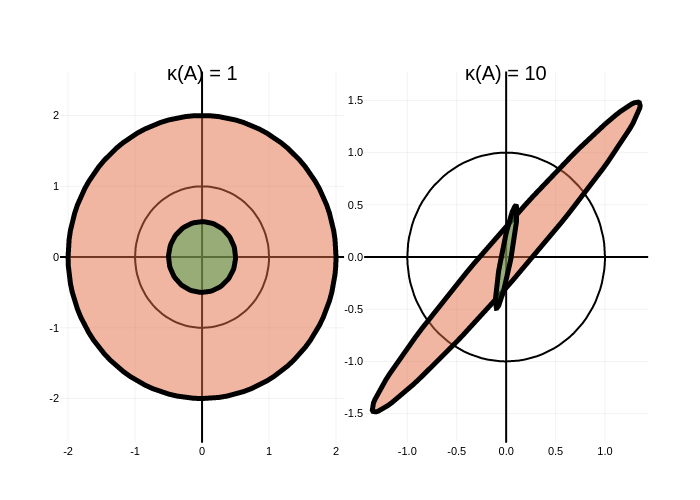

In [4]:
n = 100; θ = LinRange(0,2π,n+1); x = cos.(θ); y = sin.(θ); xy = [x y]';

A1 = 2 * I; A2 = 0.5 * I;

xy1 = A1 * xy; xy2 = A2 * xy;
p = plot(x, y, l=(2,:black))
plot!(p, [xy1[1,:] xy2[1,:]], [xy1[2,:] xy2[2,:]]
    , st = :shape
    , aspect_ratio = :equal
    , framestyle = :zerolines
    , fillalpha = 0.5
    , title="κ(A) = 1"
)

σ = [1, 1/10] 
U3 = qr(randn(2,2)).Q; V3 = qr(randn(2,2)).Q
U4 = qr(randn(2,2)).Q; V4 = qr(randn(2,2)).Q

A3 = 2 * U3 * diagm(σ) * V3';
A4 = 0.5 * U4 * diagm(σ) * V4';

xy3 = A3 * xy; xy4 = A4 * xy;
q = plot(x, y, l=(2,:black))
plot!(q, [xy3[1,:] xy4[1,:]], [xy3[2,:] xy4[2,:]]
    , st = :shape
    , aspect_ratio = :equal
    , framestyle = :zerolines
    , fillalpha = 0.5
    , title="κ(A) = 10"
)
plot(p, q, layout=(1,2), size=(1300,800))

### Floating point arithmetic

We treat a floating point system $\mathbf{F}\subset\mathbb{R}$ as though there is one number $\epsilon_{\text{machine}}$ that:

1. bounds the _relative error_ of projection $\mathrm{fl}: \mathbb{R} \to \mathbf{F}$:

$$\frac{|\mathrm{fl}(x) - x|}{|x|} \leq \epsilon_{\text{machine}}.$$

In [ ]:
function floating_point_bytes(exponent_digits)
    @assert exponent_digits >= 2 && exponent_digits <= 7
    mantissa_digits = 7 - exponent_digits
    e_max = 2^(exponent_digits - 1) - 1
    e_min = 1 - e_max
    bias = e_max
    V = Vector{Float64}(undef, 0)
    for sign in [-1, 1.]
        # subnormal numbers
        for mantissa in 0:2^mantissa_digits - 1
            frac = mantissa / 2^mantissa_digits
            push!(V, sign * 2. ^e_min * frac)
        end
        # normal numbers
        for ex in e_min:e_max
            for mantissa in 0:2^mantissa_digits - 1
                frac = (2^mantissa_digits + mantissa) / 2^mantissa_digits
                push!(V, sign * 2. ^ex * frac)
            end
        end
    end
    return sort(V)
end
p = plot(title = "Absolute error spacing", ylim=(-1,1))
V = filter(x -> x > 0., floating_point_bytes(4))
plot!(p, V
    , zeros(length(V))
    , line = nothing
    , marker = :cross
)
q = plot(xlabel = "ℝ", title = "Relative error spacing", xscale=:log10, ylim=(-1,1))
V = filter(x -> x > 0., floating_point_bytes(4))
plot!(q, V
    , zeros(length(V))
    , line = nothing
    , marker = :cross
)
plot(p, q, layout=(2,1)
    , plot_title = "Positive 8-bit floating point values for exponent"
    , size=(1300,450)
    , bottom_margin=3Plots.mm
)

2. (Fundamental axiom) For every basic operation $\ast\in\{+, -, \times, \div\}: \mathbb{R}\otimes \mathbb{R} \to \mathbb{R}$ with floating point approximation $\circledast\in\{\bigcirc\!\!\!\!\!+\,, \bigcirc\!\!\!\!\!-\,, \bigcirc\!\!\!\!\!\times\,, \bigcirc\!\!\!\!\!\div\,\}: \mathbf{F} \otimes \mathbf{F} \to \mathbf{F}$,

$$x \circledast y = (x \ast y)(1 + \epsilon), \quad |\epsilon| \leq \epsilon_{\text{machine}}.$$

$$\Rightarrow \frac{|x \circledast y| - |x \ast y|}{|x \ast y|} \leq \epsilon_{\text{machine}}.$$

In [ ]:
n_samples = 100;
x = randn(Float32, n_samples)
y = randn(Float32, n_samples)
z_true = Float64.(x) - Float64.(y)
z_fl32 = x - y
r = abs.(Float64.(z_fl32) - z_true) ./ abs.(z_true)
plot(z_true, r, st=:scatter, m=:utriangle)
plot!([minimum(z_true),maximum(z_true)], eps(Float32)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), xlabel="x-y", title = "x-y floating point relative error, 32-bit")

### Accuracy, Stability, and Backward Stability

of _algorithm_ $\tilde{f}_{\epsilon}: X \to Y$ that approximates problem $f: X \to Y$ with floating point precision $\epsilon$.

**Accurate:**

$$\frac{\|\tilde{f}_{\epsilon}(x) - f(x)\|}{\|f(x)\|} = O(\epsilon) \text{ uniformly in }x.$$

**Stable:**  For every $x$ there is $\tilde{x}_\epsilon$, 

$$
\begin{aligned}
\frac{\|\tilde{f}_\epsilon(x) - f(\tilde{x}_\epsilon)\|}{\|f(\tilde{x}_\epsilon)\|}
&= O(\epsilon)\text{ uniformly in }x, \\
\frac{\|\tilde{x}_\epsilon - x\|}{\|x\|} 
&= O(\epsilon)\text{ uniformly in }x.
\end{aligned}
$$

**Backward stable:** For every x there is $\tilde{x}_\epsilon$,

$$
\begin{aligned}
\tilde{f}_\epsilon &= f(\tilde{x}_\epsilon) \\
\frac{\|\tilde{x}_\epsilon - x\|}{\|x\|} 
&= O(\epsilon)\text{ uniformly in }x.
\end{aligned}
$$


(The choice of norm doesn't matter.)

### Backward stability of floating point arithmetic (example: subtraction)

$$\tilde{f}(x, y) = \mathrm{fl}(x) \bigcirc\!\!\!\!\!\!-\ \ \mathrm{fl}(y)$$

$$=x(1 + \delta_1) \bigcirc\!\!\!\!\!\!-\ \ y(1 + \delta_2), \quad |\delta_1|,|\delta_2| \leq \epsilon_{\text{machine}},$$

$$= (x(1 + \delta_1) - y(1 + \delta_2))(1 + \delta_3), \quad |\delta_3| \leq \epsilon_{\text{machine}},$$

$$= \underbrace{x(1 + \delta_4)}_{\tilde{x}} - \underbrace{y(1 + \delta_5)}_{\tilde{y}}, \quad |\delta_4|,|\delta_5| \leq 2 \epsilon_{\text{machine}} + O(\epsilon_{\text{machine}}^2),$$

$$= f(\tilde{x},\tilde{y}).$$

### Verifying backward stability: backward error $O(\epsilon_{\text{machine}})?$

$$\tilde{f}(x,y) = f(\tilde{x},\tilde{y}), \quad \tilde{x} = x(1 + \delta_4), \tilde{y} = y(1 + \delta_5), \quad |\delta_4|,|\delta_5| \leq 2 \epsilon_{\text{machine}} + O(\epsilon_{\text{machine}}^2)$$

$$\frac{\max\{|x - \tilde{x}|,|y - \tilde{y}|\}}{\max\{|x|,|y|\}} \leq \frac{\max\{|x|,|y|\} \cdot
\max\{|\delta_4|,|\delta_5|\}}{\max\{|x|,|y|\}} \leq 2 \epsilon_{\text{machine}} + O(\epsilon_{\text{machine}}^2)$$

There must be $\rho > 0$ such that $\max\{|\delta_4|,|\delta_5|\} \leq 3 \epsilon_{\text{machine}}$ whenever $\epsilon_{\text{machine}} < \rho$.

$$\Rightarrow \frac{\max\{|x - \tilde{x}|,|y - \tilde{y}|\}}{\max\{|x|,|y|\}} = O(\epsilon_{\text{machine}}).$$

### On HW3 3

**3(a) restated:**  There are $g(\epsilon) = O(\epsilon)$ and $h(\epsilon)$ such that $f(\epsilon) = (1 + g(\epsilon))(1 + h(\epsilon))$.  Prove that $f(\epsilon) - 1 = O(\epsilon)$.

From the definitions, there exist, $\rho_g$, $\rho_h$, $C_g$, and $C_h$ such that

$$
\begin{aligned}
|g(\epsilon)| &\leq C_g |\epsilon|, & |\epsilon| \leq \rho_g, \\
|h(\epsilon)| &\leq C_h |\epsilon|, & |\epsilon| \leq \rho_h.
\end{aligned}
$$

Prove that similar constants exist for $(f(\epsilon) - 1)$.

**3(b) restated:** There is $g(\epsilon) = O(\epsilon)$ such that $f(\epsilon) = 1 / (1 + g(\epsilon))$.  Prove that $f(\epsilon) - 1 = O(\epsilon).$

### On HW3 4

**4(a):** Use Pascal's triangle AKA binomial expansion:

$$(1 + x)^n = \sum_{k=0}^n \binom{n}{k} x^k.$$

**4(b):** Many ways, my strategy:

1. Show that $\lim_{\epsilon \to 0} e_n(\epsilon) / \gamma_n(\epsilon) = 1.$

2. Show that $\partial_\epsilon \{e_n(\epsilon) / \gamma_n(\epsilon)\} < 0$ for all $0 < \epsilon < 1/n.$

## Stability examples and counterexamples

### Inner product

- Input space $X$?

$$\mathbb{C}^m \otimes \mathbb{C}^m$$

- Output space $Y$?

$$\mathbb{C}$$

- $f: X \to Y$?

$$f(x,y) = x^*y$$

### Inner product algorithm

- $\tilde{f}: X \to Y$?  Here for the first time we have to reckon with the fact that **floating point addition is not associative**:

$$(x \oplus y) \oplus z \neq x \oplus (y \oplus z)$$

In [ ]:
n_samples = 100;
x = randn(n_samples)
y = randn(n_samples)
z = randn(n_samples)
w_left = (x + y) + z
w_right = x + (y + z)
r = abs.(w_left - w_right) ./ max.(abs.(w_left),abs.(w_right))
plot(w_left, r, st=:scatter, m=:utriangle)
plot!([minimum(w_left),maximum(w_right)], eps(Float64)*[1,1], l=(2,:black,:dash), text=["", "ϵ"], ylim=1.1*eps(Float32), size=(650,500), xlabel="x+y+z", title = "((x ⊕ y) ⊕ z) - (x ⊕ (y ⊕ z)), relative error")

### Inner product algorithm

$$\tilde{f}(x,y) = \tilde{f}(x_{1:m-1},y_{1:m-1}) \oplus (\mathrm{fl}(\overline{x_m}) \otimes \mathrm{fl}(y_m)).$$

**Base case ($m=1$):** just floating point multiplication $\mathrm{fl}(\overline{x_1}) \otimes \mathrm{fl}(y_1)$, which we said is backward stable:

$$
(\mathrm{fl}(\overline{x_1}) \otimes \mathrm{fl}(y_1)) = \overline{x_1}(y_1 + \delta y_1), \quad
|\delta y_1| / |y_1| = O(\epsilon_{\text{machine}}).
$$

**Inductive case:** Assume $\tilde{f}(x_{1:m-1},y_{1:m-1}) = x_{1:m-1}^*(y_{1:m-1} + \delta y_{1:m-1}),$
$\|\delta y_{1:m-1}\| / \|y_{1:m-1}\| = O(\epsilon_{\text{machine}}).$

**Determine backward error:**

$$\tilde{f}(x_{1:m-1},y_{1:m-1}) \oplus (\mathrm{fl}(\overline{x_m}) \otimes \mathrm{fl}(y_m))
= x_{1:m-1}^*(y_{1:m-1} + \delta y_{1:m-1}) \oplus \overline{x_m}(y_m + \delta y_m)$$

$$
= \big(x_{1:m-1}^*(y_{1:m-1} + \delta y_{1:m-1}) + \overline{x_m}(y_m + \delta y_m)\big)(1 + \hat{\delta}), \quad
|\hat{\delta}| \leq \epsilon_{\text{machine}}.
$$

$$
=x_{1:m-1}^*(y_{1:m-1} + \underbrace{\hat{\delta}\cdot y_{1:m-1} + \delta y_{1:m-1}(1 + \hat{\delta})}_{\delta y_{1:m-1}^{\text{new}}})
+ \overline{x_m}(y_m + \underbrace{\hat{\delta}\cdot y_m + \delta y_m (1 + \hat{\delta})}_{\delta y_m^{\text{new}}})
$$

$$
=
x^*(y + \delta y^{\text{new}}).
$$

**Prove that $\|\delta y^{\text{new}}\| / \|y\| = O(\epsilon_{\text{machine}})$:** Exercise.

**Backward stable**

### Example: Outer Product

$$f(x,y) = xy^*$$

- Input space?

$$ \mathbb{C}^m \otimes \mathbb{C}^m $$

- Output space?

$$\mathbb{C}^{m \times m}$$

### Outer product algorithm

$$(\tilde{f}(x,y))_{ij} = \mathrm{fl}(x_i) \otimes \mathrm{fl}(\overline{y_j})$$

- Each entry is individually backward stable, because it is just floating point multiplication:
$$\mathrm{fl}(x_i) \otimes \mathrm{fl}(\overline{y_j}) = x_i \overline{y_j} + \delta_{ij}, \quad |\delta_{ij}| / |x_i \overline{y_j}| = O(\epsilon_{\text{machine}}).$$

- But for backward stability we would require $$
\tilde{f}(x,y) = (x + \delta x) (y + \delta y)^*$$
for some $\delta x, \delta y$, which would mean $\tilde{f}(x,y)$ is still a rank-1 matrix.

- The matrix of errors $\Delta$ looks more like a matrix of i.i.d. errors, which is almost surely full rank (HW3 Problem 1).

- **Outer product is not backward stable** (but it is stable)

> As a rule, for problems were the dimension of the solution space $Y$ is greater than that of the problem space $X$, backward stability is rare.

(whiteboard)

### Example: $f(x) = x + 1$

- Input space $X$?

$$\mathbb{C}$$

- Output space $y$?

$$\mathbb{C}$$

- $\tilde{f}?$

$$\begin{aligned}
\tilde{f}(x) &= \mathrm{fl}(x) \oplus 1 = (x(1 + \delta_1) + 1)(1 + \delta_2) \\
&= x + 1 + \underbrace{\delta_1 x + \delta_2 + \delta_1 \delta_2 x}_{\tilde{x} - x}
\end{aligned}$$

### Checking the backward error magnitude

$$
\frac{|\tilde{x} - x|}{|x|} = \frac{|\delta_1 x + \delta_2 + \delta_1 \delta_2 x|}{|x|} \neq O(\epsilon_{\text{machine}}).$$

- $|\delta_2|$ cannot be bounded relative to $|x|$: **not backward stable**

- But just plain **stable**? Yes: choose
$$
\tilde{x} = \begin{cases}
x + \delta_1 x + \delta_1\delta_2 x, & |x| < 1/2, \\
x + \delta_1 x + \delta_1\delta_2 x + \delta_2, & |x| > 1/2.
\end{cases}
$$

- In general if $f(0) \neq 0$, backward stability is rare.

### Exercise: why does this function exist?

In [ ]:
using SpecialFunctions

@doc log1p

### Unstable example: 2x2 matrix eigenvalues by root finding

$O(\epsilon_{\text{machine}})$ errors in coefficients lead to $O(\sqrt{\epsilon_{\text{machine}}})$ errors in roots (think quadratic formula).

In [ ]:
function mat_2x2_char_poly(A)
    # det(λ I - A)
    return Polynomial(Float64[det(A), -tr(A), 1])
end

In [ ]:
n_samples = 100;
rel_errs = Float64[]
for i in 1:n_samples
    C = [[1 + 1.e-14, 0.0] [randn(), 1.]]
    X = randn(2,2)
    A = X \ (C * X)
    c = mat_2x2_char_poly(A)
    eigs_roots = roots(c)
    eigs = eigvals(A)
    diff = norm(eigs_roots - eigs)
    diff = min(diff, norm(eigs_roots - eigs[[2,1]]))
    rel_err = diff / norm(eigs)
    push!(rel_errs, rel_err)
end
p = plot(1:n_samples, rel_errs
    , st = :scatter
    , ylim=(1.e-16,1.e-0)
    , yscale=:log10
    , title="relative error in eigenvalues via characteristics polynomial roots")
plot!(p,[1,n_samples],[eps(),eps()],l=(2,:black,:dash))
annotate!(p, n_samples /2, log10(eps())+0.5, ("ϵ"))
plot!(p,[1,n_samples],[eps()^0.5,eps()^0.5],l=(2,:black,:dash))
annotate!(p, n_samples /2, log10(eps()^0.5)+0.5, ("√ϵ"))

## Accuracy of a Backward Stable Algorithm

If $\tilde{f}$ is backward stable, then **accuracy is proportional to conditioning**

**T&B Theorem 15.1.** Suppose a backward stable algorithm is applied to solve a problem $f: X \to Y$ with condition number $\kappa$ on a computer satisfying the floating point axioms.  Then the relative errors satisfy

$$
\frac{\|\tilde{f}(x) - f(x)\|}{\|f(x)\|} = O(\kappa(x) \epsilon_{\text{machine}}).
$$

_Proof._

$$\begin{aligned}
\frac{\|\tilde{f}(x) - f(x)\|}{\|f(x)\|}
&=
\frac{\|\overbrace{\tilde{f}(x) - f(\tilde x)}^0 +  f(\tilde x) - f(x)\|}{\|f(x)\|} \\
&=
\frac{\|f(\tilde x) - f(x)\|}{\|f(x)\|} \\
&\leq (\kappa(x) + o(1)) \frac{\|\tilde x - x\|}{\|x\|} \\
&= O(\kappa(x) \epsilon_{\text{machine}}).
\end{aligned}$$

### This is Backward Error Analysis

$$\frac{\|\tilde{f}(x) - f(x)\|}{\|f(x)\|}
\leq
\frac{\|\tilde{f}(x) - f(\tilde x)\|}{\|f(x)\|} +  \frac{\|f(\tilde x) - f(x)\|}{\|f(x)\|}
$$

- The first term is controlled by the **stability of the algorithm** (in fact zero if it is backward stable)

- The second term is controlled by the **conditioning of the problem**

## Stability of Householder Triangularization

### Householder QR is backward stable: Experiment

In [ ]:
m = 50

R = triu(randn(m,m));

Q = qr(randn(m,m)).Q;

A = Q * R;

Q2, R2 = qr(A);

In [ ]:
display(norm(Q2 - Q))
display(norm(R2-R) / norm(R))

### Repeat, but with the convention that the diagonal of `R` and `R2` are non-negative

In [ ]:
m = 40

R = triu(randn(m,m));

Q = qr(randn(m,m)).Q;

Q = Q * diagm(sign.(diag(R))); R = diagm(sign.(diag(R))) * R;

A = Q * R;

Q2, R2 = qr(A);

Q2 = Q2 * diagm(sign.(diag(R2))); R2 = diagm(sign.(diag(R2))) * R2;

In [ ]:
display(norm(Q2 - Q))
display(norm(R2-R) / norm(R))

What have we learned about accuracy / stability / backward stability of Householder QR?

### Observe the reconstruction error

In [ ]:
display(norm(A - Q2 * R2) / norm(A))

Now what have we learned about accuracy / stability / backward stability?

### Householder in the stability analysis terms

$$f: A \mapsto (Q, R)$$

$$\tilde{f}: A \mapsto (\tilde{Q}, \tilde{R})$$

$$\max\{\|\tilde{Q} - Q\|/\|Q\|, \|\tilde{R} - R\| / \|R\|\} = \frac{\|\tilde{f}(x) - f(x)\|}{\|f(x)\|}$$

$$\frac{\|A - \tilde{Q}\tilde{R}\|}{\|A\|} = \frac{\|A - \tilde{A}\|}{\|A\|} = \frac{\|x - \tilde x\|}{\|x\|}.$$

We have observed large forward errors (the problem is ill-conditioned), but small backward errors (the algorithm is stable? needs proof)

### T&B Theorem 16.1

Let the QR factorization $A = QR$ of a matrix $A \in \mathbb{C}^{m \times n}$ be computed by Householder triangularization on a computer satisfying the floating point axioms, and let the computed $\tilde{Q}$ be

$$
\tilde{Q} = \tilde{Q}_1 \tilde{Q}_2 \dots \tilde{Q}_n,
$$

where $\tilde{Q}_k$ is the Householder reflector of the computed reflector $\tilde{v}_k$.  Then

$$\tilde{Q}\tilde{R} = A + \delta A, \quad \frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})$$

for some $\delta A \in \mathbb{C}^{m \times n}$.

### Exercise

In [ ]:
function svd_accuracy_test(m, pow=1)
    U = qr(randn(m,m)).Q # random unitary U
    V = qr(randn(m,m)).Q # random unitary V
    σ = rand(m) # random singular values
    A = U * diagm(σ) * V' # construct A
    U2, σ2, V2 = svd(A) # refactorize
    # compute errors
    return [norm(U-U2) norm(V-V2) norm(σ-σ2)/norm(σ) norm(A - U2 * diagm(σ2) * V2')/norm(A) cond(A)]
end

In [ ]:
m = 50
n_tests = 100
data = vcat([svd_accuracy_test(m) for i in 1:n_tests]...);
data = log10.(data)
uplot = plot(data[:,5], data[:,1], st=:scatter, xlabel="log₁₀(cond(A))", title="log₁₀||U - U₂||")
vplot = plot(data[:,5], data[:,2], st=:scatter, xlabel="log₁₀(cond(A))", title="log₁₀||V - V₂||")
splot = plot(data[:,5], data[:,3], st=:scatter, xlabel="log₁₀(cond(A))", title="log₁₀||Σ - Σ₂||/||Σ||")
aplot = plot(data[:,5], data[:,4], st=:scatter, xlabel="log₁₀(cond(A))", title="log₁₀||A - U₂Σ₂V₂'||/||A||")
plot(uplot, vplot, splot, aplot, layout=(2,2), plot_title="m=$m")